# Predicting NHL Regular Season Wins: Multiple Linear Regression Analysis (2007–2023)

---

## Introduction

This multiple linear regression analysis investigates NHL team metrics from **2007 to 2023** to uncover key predictors of regular season wins. The dataset reflects all available data, including metrics like CORSI and Fenwick, faceoff win percentage, etc.

## Hypothesis

### Null Hypothesis (H₀)
There is no predictive relationship between NHL team metrics and the number of team wins during the regular season.

### Alternative Hypothesis (H₁)
There is a predictive relationship between NHL team metrics and team wins, meaning that team metrics have a significant impact on predicting the number of wins a team could achieve during the regular season.

## Data Source and Methodology

- **Data Sources:**  
  The dataset is sourced from the [NHL API](https://github.com/Zmalski/NHL-API-Reference) and [www.naturalstattrick.com](https://www.naturalstattrick.com/glossary.php?teams#), which provides enriched and accurate raw NHL season data per team. Definitions and documentation of these metrics are available [HERE](https://nhl-db-documentation.netlify.app/#!/overview).
  
- **Methodology:**  
  This analysis employs **Multiple Linear Regression** to assess the relationship between team metrics and their influence on regular season wins.

---

## Practical Applications

This analysis is particularly relevant for **junior hockey coaches** seeking data-driven strategies to enhance team performance. It offers:

- **Actionable Insights:** Highlights critical metrics for improving team success.
- **Strategic Guidance:** Provides a framework for informed decision-making and resource allocation to optimize regular season outcomes.

Table of Contents
=================

1. [Feature Selection and Data Preprocessing](#Feature-Selection-and-Data-Preprocessing)
    - [Mitigating Overfitting Through Data Splitting](#Mitigating-Overfitting-Through-Data-Splitting)
    - [ Feature Removal Based on Variance Inflation Factor and Multicollinearity Analysis](#Feature-Removal-Based-on-Variance-Inflation-Factor-and-Multicollinearity-Analysis)
2. [Model Training and Testing](#Model-Training-and-Testing)
    - [Model Training, Evaluation, and Interpretation](#Model-Training,-Evaluation,-and-Interpretation)
    - [Shuffled K-Fold Splits in Cross-Validation](#Shuffled-K-Fold-Splits-in-Cross-Validation)
    - [Interpretation of K-Fold Cross-Validation Metrics](#Interpretation-of-K-Fold-Cross-Validation-Metrics)
    - [Interpretation of Coefficients and R²](#Interpretation-of-Coefficients-and-R²)
    - [Residuals Analysis: Train](#Residuals-Analysis:-Train)
    - [Residuals Analysis: By Index and By Wins](#Residuals-Analysis:-By-Index-and-By-Wins)
    - [Residuals Analysis: Independent Variables](#Residuals-Analysis:-Independent-Variables)
    - [The Interpretation of Season Predictions vs. Wins: Train](#The-Interpretation-of-Season-Predictions-vs.-Wins:-Train)
3. [Model Testing, Evaluation, and Interpretation](#Model-Testing,-Evaluation,-and-Interpretation)
    - [Comparison of Training and Test Results](#Comparison-of-Training-and-Test-Results)
    - [Model Test Metrics Interpretation](#Model-Test-Metrics-Interpretation)
4. [Model Finalization](#Model-Finalization)
    - [Model Finalizing, Evaluation, and Interpretation](#Model-Finalizing,-Evaluation,-and-Interpretation)
    - [Feature Importance and Coefficients Analysis](#Feature-Importance-and-Coefficients-Analysis)
5. [Clustering Analysis and Visual Interpretations](#Clustering-Analysis-and-Visual-Interpretations)
    - [Analysis of Cluster Performance and Feature Importance](#Analysis-of-Cluster-Performance-and-Feature-Importance)

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import os 
import sys

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pickle import dump
from pickle import load

from scipy.stats.mstats import normaltest
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Get the current working directory (the directory of the running script)
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'Regression_Functions')))
from Preprocessing_Functions import Preprocessing
from Regression_Metrics_Functions import Metrics

## Feature Selection and Data Preprocessing

---

In [4]:
data_path = os.path.abspath(
    os.path.join(
        current_dir,
        "..",
        "..",
        r"Dashboard\Dashboard_Data_In_Use\analysis_view.xlsx",
    )
)

df = pd.read_excel(data_path)

df = df[(df["start_year"] >= 2007) & (df["start_year"] < 2024)].reset_index(
    drop=True
)
df = df[df['game_type']=='Regular Season'].reset_index(drop=True)

df['time_on_ice'] = df['time_on_ice'].str.replace(':', '.', 1).str[:-3]
df['time_on_ice'] = df['time_on_ice'].astype(float)

# create a blocked shots feature
df['blocked_shots'] = df['corsi_against'] - df['fenwick_against']
df['shots_blocked'] = df['corsi_for'] - df['fenwick_for']

per_60_minutes_columns = [
    'blocked_shots',
    'shots_blocked',
    "corsi_for",
    "corsi_against",
    "fenwick_for",
    "fenwick_against",
    "shots_for",
    "shots_against",
    "goals_for",
    "goals_against",
    "expected_goals_for",
    "expected_goals_against",
    "scoring_chances_for",
    "scoring_chances_against",
    "scoring_chances_shots_for",
    "scoring_chances_shots_against",
    "scoring_chances_goals_for",
    "scoring_chances_goals_against",
    "high_danger_chances_for",
    "high_danger_chances_against",
    "high_danger_shots_for",
    "high_danger_shots_against",
    "high_danger_goals_for",
    "high_danger_goals_against",
    "medium_danger_chances_for",
    "medium_danger_chances_against",
    "medium_danger_shots_for",
    "medium_danger_shots_against",
    "medium_danger_goals_for",
    "medium_danger_goals_against",
    "low_danger_chances_for",
    "low_danger_chances_against",
    "low_danger_shots_for",
    "low_danger_shots_against",
    "low_danger_goals_for",
    "low_danger_goals_against",
]

for col in per_60_minutes_columns:
    df[col+"_per_60_minutes"]=df[col] * 60 / df['time_on_ice']

column_to_move = "wins"
columns = [column_to_move] + [col for col in df.columns if col!=column_to_move]
df = df[columns]

df = df.loc[df['wins']<62] # Remove outliers

df = df[[
    'wins',
    'start_year',
    'game_type',
    'games_played',
    'faceoff_win_pct',
    'penalty_kill_net_pct',
    'power_play_net_pct',
    'blocked_shots',
    'shots_blocked',
    'corsi_for',
    'corsi_against',
    'fenwick_for',
    'fenwick_against',
    'high_danger_chances_for',
    'high_danger_chances_against',
    'high_danger_shots_for',
    'high_danger_shots_against',
    'save_pct',
]]


df.info(verbose=True, show_counts=True)
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 0 to 519
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   wins                         518 non-null    int64  
 1   start_year                   518 non-null    int64  
 2   game_type                    518 non-null    object 
 3   games_played                 518 non-null    int64  
 4   faceoff_win_pct              518 non-null    float64
 5   penalty_kill_net_pct         518 non-null    float64
 6   power_play_net_pct           518 non-null    float64
 7   blocked_shots                518 non-null    int64  
 8   shots_blocked                518 non-null    int64  
 9   corsi_for                    518 non-null    int64  
 10  corsi_against                518 non-null    int64  
 11  fenwick_for                  518 non-null    int64  
 12  fenwick_against              518 non-null    int64  
 13  high_danger_chances_for  

,wins,start_year,game_type,games_played,faceoff_win_pct,penalty_kill_net_pct,power_play_net_pct,blocked_shots,shots_blocked,corsi_for,corsi_against,fenwick_for,fenwick_against,high_danger_chances_for,high_danger_chances_against,high_danger_shots_for,high_danger_shots_against,save_pct
0,46,2007,Regular Season,82,0.503966,0.847133,0.134375,641,738,3095,2818,2357,2177,561,531,439,440,0.9247
1,35,2007,Regular Season,82,0.510504,0.845333,0.100000,809,847,3279,3231,2432,2422,667,645,513,485,0.9240
2,42,2007,Regular Season,82,0.522979,0.857142,0.148648,718,744,3311,2797,2567,2079,665,635,504,495,0.9262


In [94]:
# Create a y and X data frames
y = df[["wins"]].reset_index(drop=True)
X = df[df.columns[4:]].reset_index(drop=True)

# Split y and X data frames into an 80/20 train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Concatenate X and y data for both train and test data
train_set_df = pd.concat(
    [X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1
)
test_set_df = pd.concat(
    [X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1
)

print(
    "\n",
    "<------------------------------------ Train Data ------------------------------------>".center(
        110
    ),
    "\n",
)
print(train_set_df.info())
display(train_set_df.head())
print(
    "\n",
    "<------------------------------------ Test Data ------------------------------------>".center(
        110
    ),
    "\n",
)
print(test_set_df.info())
display(test_set_df.head())


             <------------------------------------ Train Data ------------------------------------>             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   faceoff_win_pct              362 non-null    float64
 1   penalty_kill_net_pct         362 non-null    float64
 2   power_play_net_pct           362 non-null    float64
 3   blocked_shots                362 non-null    int64  
 4   shots_blocked                362 non-null    int64  
 5   corsi_for                    362 non-null    int64  
 6   corsi_against                362 non-null    int64  
 7   fenwick_for                  362 non-null    int64  
 8   fenwick_against              362 non-null    int64  
 9   high_danger_chances_for      362 non-null    int64  
 10  high_danger_chances_against  362 non-null    int64  
 11  high_danger_shots_for

,faceoff_win_pct,penalty_kill_net_pct,power_play_net_pct,blocked_shots,shots_blocked,corsi_for,corsi_against,fenwick_for,fenwick_against,high_danger_chances_for,high_danger_chances_against,high_danger_shots_for,high_danger_shots_against,save_pct,wins
0,0.492180,0.901234,0.138263,820,954,3579,3209,2625,2389,622,607,476,492,0.9268,49
1,0.536172,0.784671,0.117154,858,909,3440,3646,2531,2788,544,659,398,503,0.9069,22
2,0.511491,0.775784,0.114537,861,912,3398,3693,2486,2832,602,749,465,581,0.9242,30
3,0.501621,0.850490,0.146814,512,575,2719,2612,2144,2100,481,519,377,425,0.9365,47
4,0.488676,0.852631,0.175355,738,716,3030,2927,2314,2189,572,539,452,430,0.9154,40



             <------------------------------------ Test Data ------------------------------------>              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   faceoff_win_pct              156 non-null    float64
 1   penalty_kill_net_pct         156 non-null    float64
 2   power_play_net_pct           156 non-null    float64
 3   blocked_shots                156 non-null    int64  
 4   shots_blocked                156 non-null    int64  
 5   corsi_for                    156 non-null    int64  
 6   corsi_against                156 non-null    int64  
 7   fenwick_for                  156 non-null    int64  
 8   fenwick_against              156 non-null    int64  
 9   high_danger_chances_for      156 non-null    int64  
 10  high_danger_chances_against  156 non-null    int64  
 11  high_danger_shots_for

,faceoff_win_pct,penalty_kill_net_pct,power_play_net_pct,blocked_shots,shots_blocked,corsi_for,corsi_against,fenwick_for,fenwick_against,high_danger_chances_for,high_danger_chances_against,high_danger_shots_for,high_danger_shots_against,save_pct,wins
0,0.533887,0.870748,0.177514,624,612,2256,2145,1644,1521,398,326,290,248,0.9282,25
1,0.485861,0.799295,0.107806,1006,852,3277,3660,2425,2654,723,687,566,531,0.9042,38
2,0.486440,0.858858,0.158469,780,687,3033,3080,2346,2300,588,507,493,410,0.9142,39
3,0.481271,0.805555,0.161585,855,797,3350,3588,2553,2733,624,620,472,466,0.9200,37
4,0.517256,0.849315,0.126126,1057,1076,3912,3952,2836,2895,852,848,586,585,0.9279,42


### Mitigating Overfitting Through Data Splitting

To mitigate overfitting, the data is split into a 70/30 train-test split. Feature selection is performed on the training set to ensure robust evaluation. The selected features are applied to the test set to validate their generalizability, providing an unbiased assessment of model performance. Cross-validation is also employed to enhance consistency and reduce overfitting.

In [96]:
# Removes features one by one to measure their VIF scores for threshold of 1.5
vif_df = train_set_df.copy()
col_length = len(vif_df.columns)

vif = Preprocessing.calculate_vif(
    X=vif_df, 
    target="wins", 
    threshold=1.5, 
    feature_elim=col_length, 
    print_markdown="no"
)

vif

,vif,features
0,12696.367991,Intercept
1,1.119008,penalty_kill_net_pct
2,1.109897,save_pct
3,1.089326,faceoff_win_pct
4,1.080546,power_play_net_pct
5,1.046216,high_danger_shots_for



dropped features:


(['blocked_shots',
  'shots_blocked',
  'fenwick_for',
  'fenwick_against',
  'high_danger_chances_against',
  'high_danger_chances_for',
  'corsi_against',
  'corsi_for',
  'high_danger_shots_against'],
 [inf,
  inf,
  76.17553389734495,
  39.44212770602449,
  35.85897307838517,
  17.729794218485996,
  4.673921159647116,
  3.2663780427262994,
  2.0445711114689904])

### Feature Removal Based on Variance Inflation Factor and Multicollinearity Analysis

Features were eliminated one by one based on their Variance Inflation Factor (VIF) scores. Any feature with a VIF score greater than 1.5 was removed to address multicollinearity and ensure a more robust analysis.

* **`blocked_shots`**
* **`shots_blocked`**
* **`fenwick_for`**
* **`fenwick_against`**
* **`high_danger_chances_against`**
* **`high_danger_chances_for`**
* **`corsi_against`**
* **`corsi_for`**
* **`high_danger_shots_against`**

In [97]:
print(
    "\n",
    "<------------------------------------ Train Data ------------------------------------>".center(
        110
    ),
    "\n",
)
# Remove list of features from train data to accomodate VIF score threshold
train_set_df = train_set_df.drop(
    vif[0] + ['faceoff_win_pct'], axis=1, errors="ignore"
)
X_train_df = train_set_df[train_set_df.columns[0:-1]]
y_train_df = train_set_df[["wins"]]

print(X_train_df.info())
display(X_train_df.head())
print("\n")
print(y_train_df.info())
display(y_train_df.head())

print(
    "\n",
    "<------------------------------------ Test Data ------------------------------------>".center(
        110
    ),
    "\n",
)
# Remove list of features from test data to accomodate VIF score threshold
test_set_df = test_set_df.drop(
    vif[0] + ['faceoff_win_pct'], axis=1, errors="ignore"
)
X_test_df = test_set_df[test_set_df.columns[0:-1]]
y_test_df = test_set_df[["wins"]]

print(X_test_df.info())
display(X_test_df.head())
print("\n")
print(y_test_df.info())
display(y_test_df.head())


             <------------------------------------ Train Data ------------------------------------>             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   penalty_kill_net_pct   362 non-null    float64
 1   power_play_net_pct     362 non-null    float64
 2   high_danger_shots_for  362 non-null    int64  
 3   save_pct               362 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 11.4 KB
None


,penalty_kill_net_pct,power_play_net_pct,high_danger_shots_for,save_pct
0,0.901234,0.138263,476,0.9268
1,0.784671,0.117154,398,0.9069
2,0.775784,0.114537,465,0.9242
3,0.850490,0.146814,377,0.9365
4,0.852631,0.175355,452,0.9154




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   wins    362 non-null    int64
dtypes: int64(1)
memory usage: 3.0 KB
None


,wins
0,49
1,22
2,30
3,47
4,40



             <------------------------------------ Test Data ------------------------------------>              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   penalty_kill_net_pct   156 non-null    float64
 1   power_play_net_pct     156 non-null    float64
 2   high_danger_shots_for  156 non-null    int64  
 3   save_pct               156 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 5.0 KB
None


,penalty_kill_net_pct,power_play_net_pct,high_danger_shots_for,save_pct
0,0.870748,0.177514,290,0.9282
1,0.799295,0.107806,566,0.9042
2,0.858858,0.158469,493,0.9142
3,0.805555,0.161585,472,0.9200
4,0.849315,0.126126,586,0.9279




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   wins    156 non-null    int64
dtypes: int64(1)
memory usage: 1.3 KB
None


,wins
0,25
1,38
2,39
3,37
4,42


In [98]:
# Observe independant variable correlations to create or bucket broader variables
corr = train_set_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,penalty_kill_net_pct,power_play_net_pct,high_danger_shots_for,save_pct,wins
penalty_kill_net_pct,1.000000,0.125224,0.093975,0.285711,0.435178
power_play_net_pct,0.125224,1.000000,0.162222,0.141811,0.448278
high_danger_shots_for,0.093975,0.162222,1.000000,0.045365,0.605903
save_pct,0.285711,0.141811,0.045365,1.000000,0.419963
wins,0.435178,0.448278,0.605903,0.419963,1.000000


As noted earlier, features with high VIF scores were removed. Additionally, **`'faceoff_win_pct`** was removed as the feature was not statistically significant (p-value > 0.05). This was identified during the first run of the regression analysis.

further more the traget variable for the train and test data are seperated into their own data frames to fit the multiple linear regression model.

## Model Training and Testing

---

### Model Training, Evaluation, and Interpretation  


In [99]:
k_fold = ShuffleSplit(
    n_splits=10, 
    random_state=0, 
    test_size=0.20, 
    train_size=None
)

print("\n" + "Train and Test Shuffled K-Fold Data:" + "\n")
for train_index, test_index in k_fold.split(X_train_df):
    print("train index:", train_index[:10], "length:", len(train_index))
    print("test index:", test_index[:10], "length:", len(test_index))
    print("")



Train and Test Shuffled K-Fold Data:

train index: [ 63 289 252 346  78 144  21 141 286  49] length: 289
test index: [186 274  45  26 217 206 324 158 113   6] length: 73

train index: [  2   9 239 241 217 230 199  42 358 318] length: 289
test index: [306 290  40  16  14 221 267  31 252 103] length: 73

train index: [309 106  99 137 271  31 138 254  32 186] length: 289
test index: [ 36 248  35  69  39 195 159  42  49 259] length: 73

train index: [349 319 358 189   9  22  62 216  17 299] length: 289
test index: [291 304 294  52  31  11  74 323  97 230] length: 73

train index: [228  98 173 336 289 294 291 202 275  13] length: 289
test index: [ 77  53 223  68  57 257 100 354  70 314] length: 73

train index: [105 301  86  66 319   8 206 168  46  55] length: 289
test index: [264  19 314 290  34 352 293 271 327 179] length: 73

train index: [338  86 305 184 152  96  88 265 117 201] length: 289
test index: [198  89 142 219  36  64 129 321  81 136] length: 73

train index: [ 56 345 320 174 

### Shuffled K-Fold Splits in Cross-Validation

The table above outlines the shuffled k-fold splits used in the cross-validation process. This method ensures robust model evaluation by splitting the data into multiple folds, each consisting of a training set and a test set.

* The data is shuffled before splitting to reduce bias and ensure each fold is representative of the dataset.
* Each fold's test set makes up 20% of the total training data, while the remaining 80% is used for training.
* This process repeats across all folds, allowing each fold to serve as the test set once.

Shuffled k-fold cross-validation helps minimize overfitting and provides a reliable estimate of the model’s generalizability to unseen data.


test model f-fold metrics:



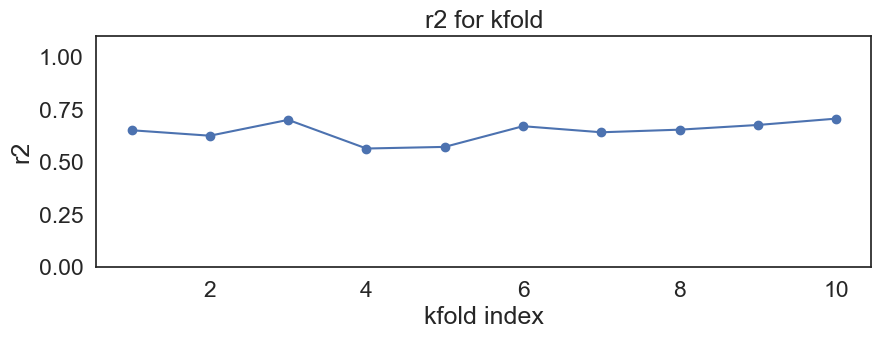

r-squared k-fold cross validation:                 ................0.65
r-squared std:                                     ................0.05


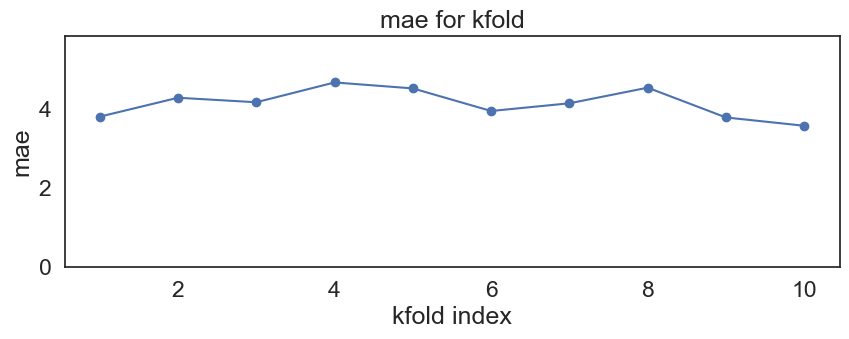



mean absolute error k-fold cross validation:       ................4.15
mean absolute error std:                           ................0.37


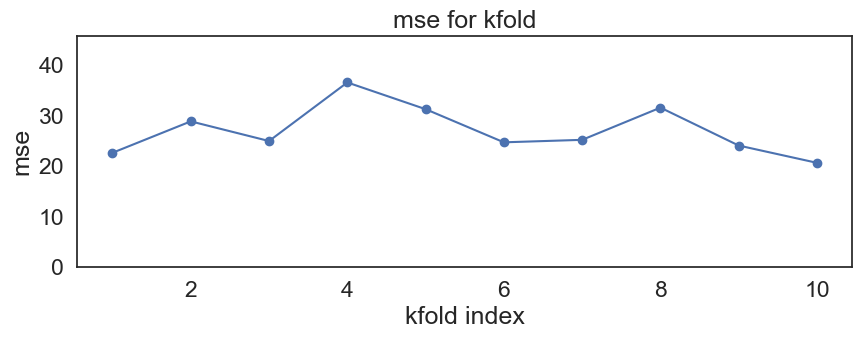



mean squared error k-fold cross validation:        ...............27.08
mean squared error std:                            ................4.89


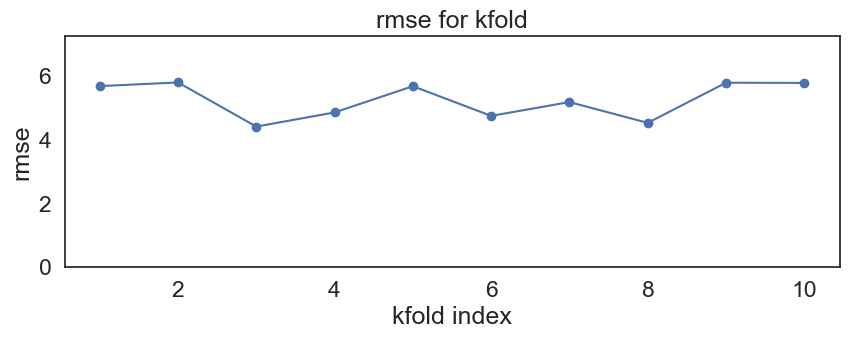



root mean squared error k-fold cross validation:   ................5.26
root mean squared error std:                       ................0.57




In [100]:
# K-fold cross validation regression evaluation metrics for train data
Metrics.regression_cross_val_shuffle(
    regressor=LinearRegression(), 
    X_train=X_train_df, 
    y_train=y_train_df, 
    cv=k_fold, 
    font=1.5
)

### Interpretation of K-Fold Cross-Validation Metrics

The four graphs collectively represent key metrics from a k-fold cross-validation process for evaluating a model: Mean Absolute Error (MAE), Mean Squared Error (MSE), R² (coefficient of determination), and Root Mean Squared Error (RMSE). Here's the interpretation:

#### 1. R² for K-Fold
- The R² scores hover consistently between 0.75 and 1 averaging 0.50, showing a decent fit for most folds.

#### 2. MAE (Mean Absolute Error) for K-Fold
- The MAE values remain relatively consistent.This indicates that the absolute prediction error is stable accross the folds.

#### 3. MSE (Mean Squared Error) for K-Fold
- The MSE shows more volatility between the folds.
- Since MSE penalizes larger errors more heavily than MAE, this suggests that folds 4, 5, 8, and 10 may have outliers or predictions with larger errors compared to other folds.

#### 4. RMSE (Root Mean Squared Error) for K-Fold
- The RMSE shows a different trend where the folds what appear to be less volatile. This metric confirms the presence of larger errors in specific folds but overall stable performance.

---

### Combined Analysis:
- **Performance Stability**: The model performs consistently well across most folds, with minor variability observed in folds.
- **Outliers or Variability**: The varability in errors across the folds suggest the presence of outliers or data points where the model struggles to make accurate predictions.
- **Cross-Validation Reliability**: The metrics indicate that the model has reasonably strong predictive power, with R² scores near or above 0.65 and relatively low error metrics (MAE and RMSE) across folds.

In [101]:
# Keep X_train and X_test as DataFrames to retain column names
X_train = X_train_df.iloc[:, :]
X_test = X_test_df.iloc[:, :]

# Ensure y_train and y_test are reshaped correctly
y_train = y_train_df.iloc[:, :].values
y_test = y_test_df.iloc[:, :].values

# Fit and train model using sklearn
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict with X_train data
y_pred_train = regressor.predict(X_train)

# Create a DataFrame for predicted results
y_pred_train_df = pd.DataFrame(
    y_pred_train, columns=["predictions_train"]
).reset_index()

# Create a single DataFrame with all prediction and actual y data
y_train_df = pd.DataFrame(y_train, columns=["wins"]).reset_index()
pred_train_df = pd.merge(y_pred_train_df, y_train_df, on="index")
y_pred_train_df = y_pred_train_df.drop(["index"], axis=1, errors="ignore")
y_train_df = y_train_df.drop(["index"], axis=1, errors="ignore")
pred_train_df["residuals_train"] = (
    pred_train_df["predictions_train"] - pred_train_df["wins"]
)

print("\n")
pred_train_df.info()
display(pred_train_df.head())

# Add a constant (intercept) to X_train and X_test for OLS
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the OLS model using statsmodels
model = sm.OLS(y_train, X_train_sm).fit()

print("\n")
# Display the summary of the regression
print(model.summary())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              362 non-null    int64  
 1   predictions_train  362 non-null    float64
 2   wins               362 non-null    int64  
 3   residuals_train    362 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 11.4 KB


,index,predictions_train,wins,residuals_train
0,0,43.868839,49,-5.131161
1,1,23.348485,22,1.348485
2,2,31.675101,30,1.675101
3,3,38.207542,47,-8.792458
4,4,38.216289,40,-1.783711




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     189.8
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           5.24e-87
Time:                        20:26:45   Log-Likelihood:                -1110.0
No. Observations:                 362   AIC:                             2230.
Df Residuals:                     357   BIC:                             2249.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -344.

### Interpretation of Coefficients and R²

#### R² Interpretation
- The **R² score of 0.680** and the **Adjusted R² of 0.677** demonstrate that the model explains ~68% of the variance in the target variable. 
- This high R² aligns with the robustness of the predictors, indicating that the model effectively captures key relationships in the data.
- The minimal gap between R² and Adjusted R² suggests that the included predictors contribute meaningfully to the model, with limited overfitting.

---

#### Coefficients Interpretation
- The coefficients provide insights into the impact of each predictor on the target variable, with statistical significance determined by **p-values < 0.05**. Key takeaways include:

#### Positive Predictors

1. **penalty_kill_net_pct (71.89)**  
   - **Most impactful positive predictor**  
   - Reflects the ability not only to kill penalties but potentially to create short-handed offense. This strong coefficient suggests that penalty-killing success is highly correlated with overall team performance.

2. **power_play_net_pct (73.57)**  
   - **Highlights special teams’ influence**  
   - A strong power play that capitalizes on opportunities (and avoids allowing short-handed goals) significantly boosts outcomes.

3. **high_danger_shots_for (0.057)**  
   - **Getting into premium scoring chances**  
   - Generating high-danger shots for fuels team performance, though its impact is much smaller than special-teams and save percentage metrics.

4. **save_pct (308.82)**  
   - **Any additional save helps**  
   - Save percentage plays an important role in determining outcomes. This means stopping pucks can have a game-changing impact. While robbing a high-danger chance is the most influential, even routine saves keep the team in control, preventing shifts in momentum and giving skaters the confidence to push forwards. Additionally, even if blocked shots is not in the equation due to multi-coliniarity, less saves made can boost the the save percentage and is advisable given players do not get hurt in the process. This is would also be true for strong defence.

#### Negative Predictors

1. **high_danger_goals_against_per_60_minutes (-9.45)**  
   - **Vulnerability in high-danger areas is costly**  
   - Letting opponents convert premium chances negatively impacts the team’s overall performance in a significant way.

2. **const (-59.72)**  
   - **Baseline (intercept) value**  
   - The negative intercept sets the starting point when all predictors are zero. It’s not itself a “predictor,” but it frames how much other variables must contribute to reach a positive outcome.


---

### Combined Insights
- The **high R² scores** and statistically significant coefficients underscore the strength and reliability of the model in capturing key predictors.
- In summary, the regression model provides a reasonably strong and interpretable framework for understanding the relationships between predictors and the target variable, offering actionable insights into the factors that drive success.


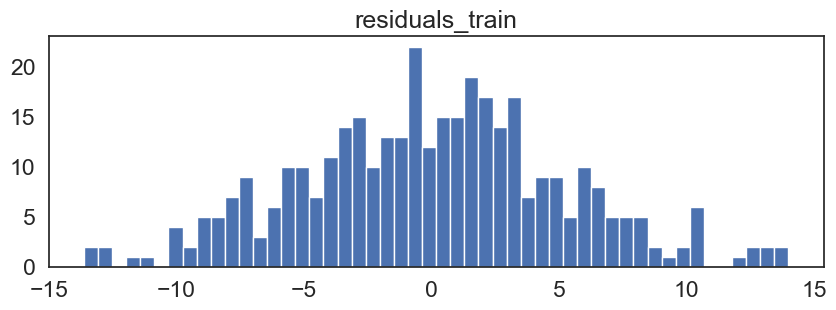


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
residuals_train,362.0,-8.746349e-14,5.200097,-13.626471,-3.407512,0.064809,3.158067,14.004664



normality test:

statistic: 0.88
p-value: 0.26



In [102]:
# residuals_train distribution
wins = pred_train_df[["residuals_train"]]

Preprocessing.num_univariate_histogram(
    df=wins, 
    length=3, 
    width=10, 
    rows=1, 
    col=1, 
    font=1.5
)

print(
    "\n"
    + "normality test:"
    + "\n"
    + "\n"
    + "statistic: "
    + str(round(normaltest(wins.residuals_train.values)[1], 2))
    + "\n"
    + "p-value: "
    + str(round(normaltest(wins.residuals_train.values)[0], 2))
    + "\n"
)


### Residuals Analysis: Train

#### Observations from the Residuals Plot
1. **Normal Distribution of Residuals**:
   - The histogram of residuals forms a bell-shaped curve, indicating that the residuals are approximately normally distributed.
   - The **p-value of .26** from the normality test confirms this, as it is greater than the standard threshold of 0.05, suggesting no significant deviation from normality.

2. **Mean of Residuals**:
   - The **mean of the residuals is fairly close to 0** (-8.75), which aligns with the assumptions of linear regression. This indicates that, on average, the model's predictions are unbiased.

3. **Spread of Residuals**:
   - The **standard deviation of 5.20** shows the typical spread of errors, and most residuals are concentrated near 0, with a few outliers on both ends.

4. **Outliers**:
   - The residuals show some outliers in the right and left tails, with values roughly around **-13.63 and 14.00**.
   - These outliers indicate instances where the model overpredicted the number of **wins**. While these cases are minimal, they suggest areas where the model may struggle to generalize.

---

### Descriptive Statistics
- **Minimum and Maximum Residuals**:
  - The residuals range from **-13.63 to 14.00**, showing that the largest errors are approximately -14 and + 14 wins.
- **Quartiles**:
  - The residuals are tightly clustered within the interquartile range, as seen from the 25th percentile (-3.41) and the 75th percentile (3.16). This further supports that the majority of errors are small.

---

### Combined Insights
- The residuals' normal distribution and near-zero mean indicate that the model's assumptions hold well and that it performs consistently across the training data.
- While there are some outliers, the majority of errors are within a reasonable range, suggesting the model is robust but could potentially be improved to address edge cases.
- Further investigation into the outliers may reveal specific patterns or data points that the model fails to predict accurately, which could inform additional feature engineering or adjustments to the model.

In conclusion, the residuals analysis confirms that the model fits the training data well, with only a few areas for potential refinement.


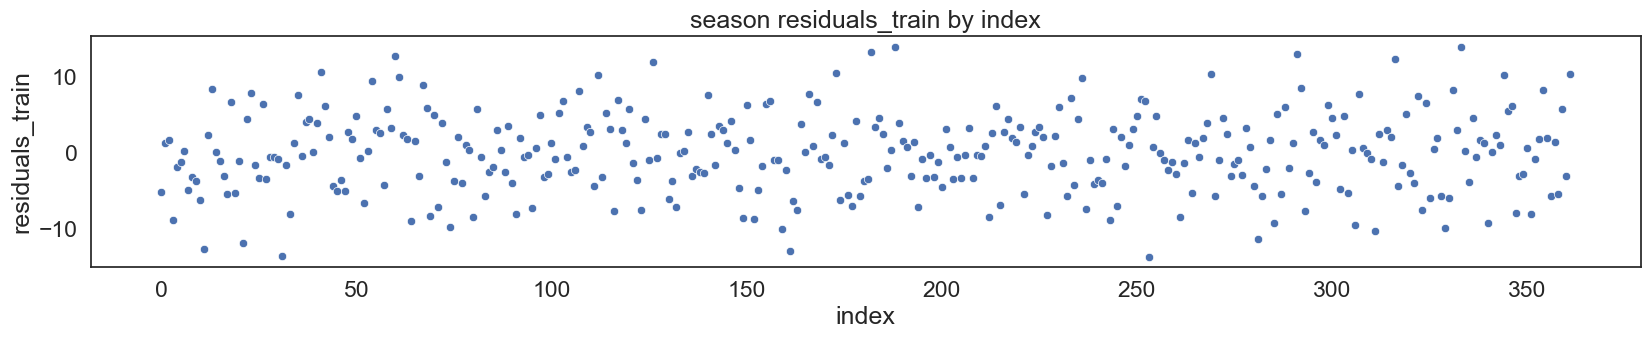

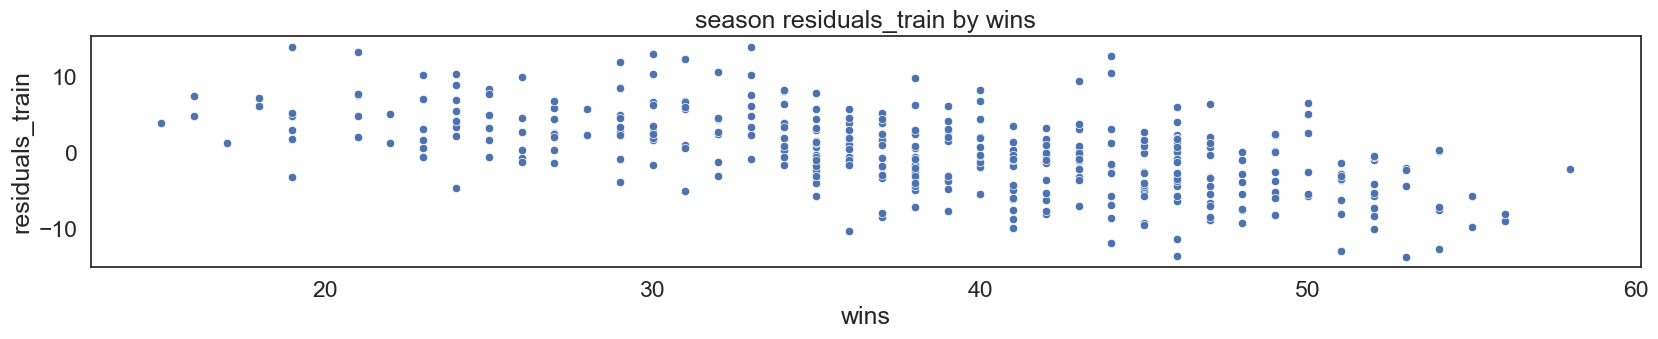

In [103]:
# residuals_train by index scatter plot
Preprocessing.target_univariate_scatter(
    df=pred_train_df, 
    x='index', 
    y='residuals_train',
    length=3, 
    width=20,
    font=1.5
)

# residuals_train by wins scatter plot
Preprocessing.target_univariate_scatter(
    df=pred_train_df,
    x='wins',
    y='residuals_train',
    length=3,
    width=20, 
    font=1.5
)

### Residuals Analysis: By Index and By Wins

The two scatter plots provide insights into the residuals from the training data, showing their distribution against **index** (top) and **wins** (bottom). Here's the interpretation:

#### Residuals by Index
1. **Random Distribution**:
   - The residuals appear to be randomly scattered across the index range, with no discernible pattern or trend.
   - This indicates that the model does not exhibit systematic errors or bias related to the order of the data points.

2. **Consistent Range**:
   - The residuals are mostly contained within the range of **-13.63 to 14.00**, further supporting the notion of relatively low prediction errors.

#### Residuals by Wins
1. **Centered Around Zero**:
   - The residuals are centered around 0 across the range of wins, which aligns with the assumption of unbiased predictions.
   - This demonstrates that the model predicts wins consistently across different levels of the target variable.

1. **No Apparent Systematic Patterns**:
   - The residuals do not exhibit clear patterns, confirming that the model's errors are random and not correlated with the target variable.

---

### Combined Insights
- The random distribution of residuals across both **index** and **wins** confirms that the model satisfies the assumptions of linear regression, specifically homoscedasticity (constant variance of residuals) and unbiased predictions.

In conclusion, the residuals plots highlight that the model performs well across the training data, with no significant biases or systematic errors, and only minor deviations in extreme cases.

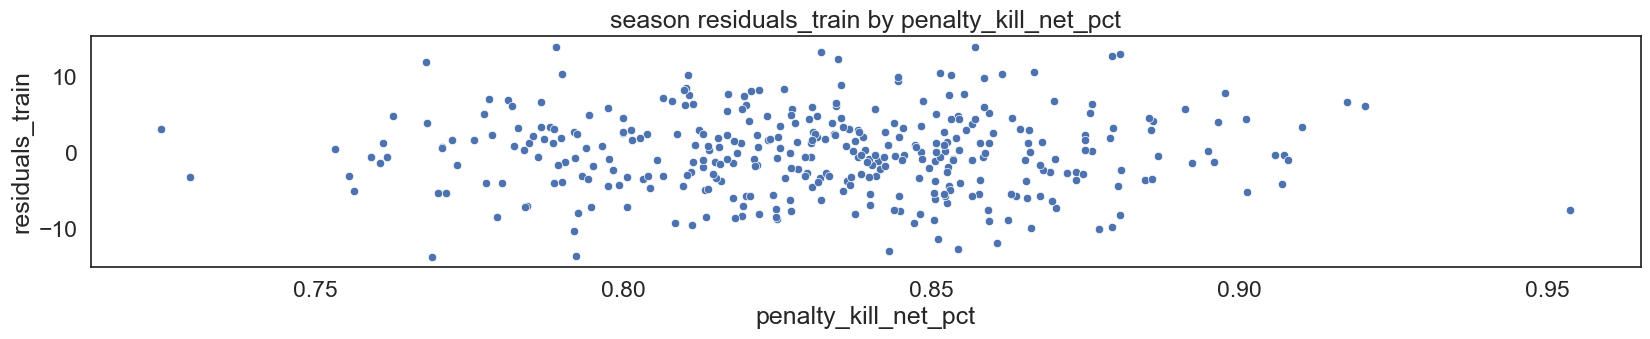

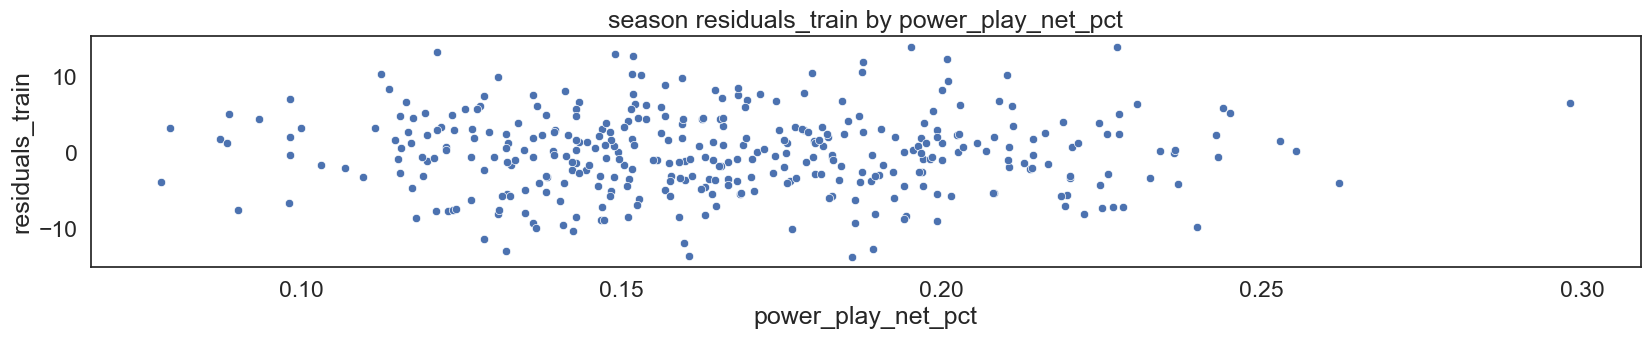

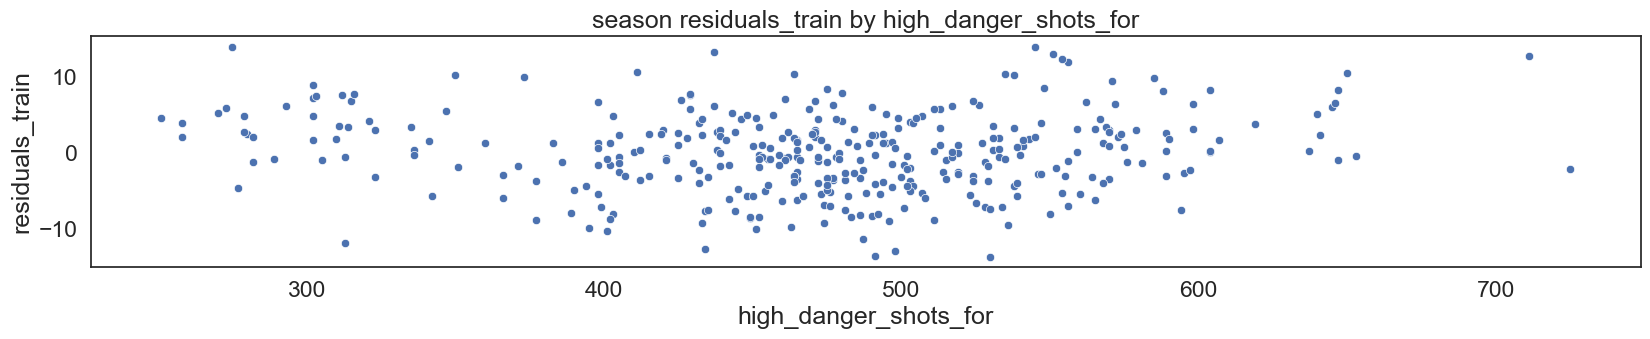

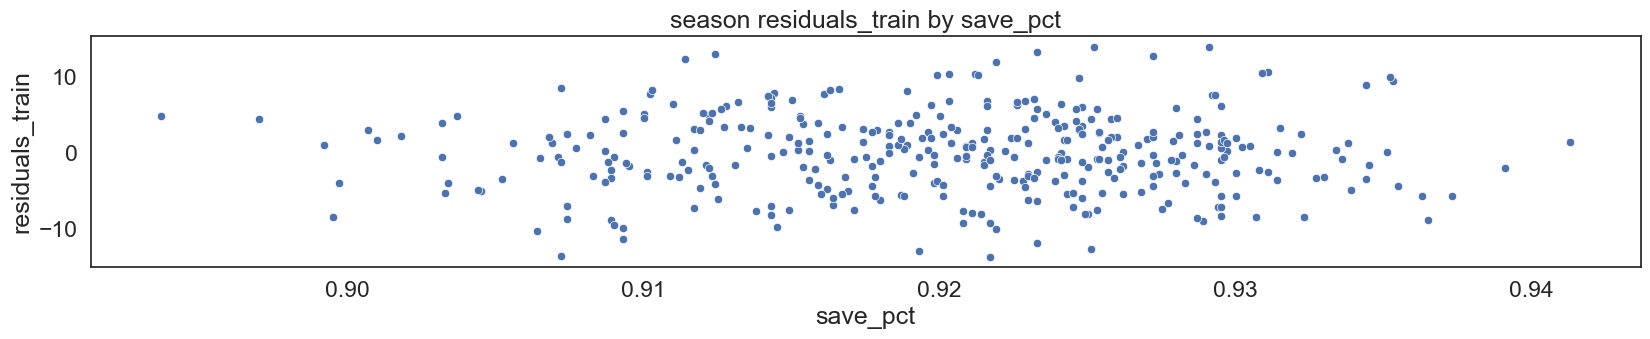

In [104]:
# residuals_train by all predictor variables plots
res_train_df = pd.concat([X_train_df, pred_train_df], axis = 1)
X_train_col = X_train_df.columns

for X in X_train_col:
    Preprocessing.target_univariate_scatter(
        df=res_train_df, 
        x=X, 
        y='residuals_train', 
        length=3, 
        width=20, 
        font=1.5
    )

### Residuals Analysis: Independent Variables

#### Observations
1. **Random Distribution of Residuals & Homoscedasticity**:
   - The residuals are scattered randomly across their range, with no discernible pattern or trend.
   - With the residuals, being scattered randomly, this suggests that the model does not systematically overpredict or underpredict based on the selected features, indicating no strong bias related to this variable.

2. **Consistent Spread Across the Range**:
   - The residuals are distributed within the range of **-13 to 14**, showing that prediction errors are relatively uniform.

3. **Potential Outliers**:
   - There are a few points on the far left and right of the graphs with slightly higher dispersion. These may indicate potential outliers or instances where the feature is less predictive.

---

### Combined Insight on Dependent Variables (DVs)
- The random scatter of residuals across the dependent variables, highlights that the model's residuals are **randomly distributed for most dependent variables (DVs)**.
- This randomness satisfies the key assumption of linear regression that residuals should not exhibit systematic patterns related to predictor variables.
- The absence of systematic bias across the DVs indicates that the model generalizes well to the training data, with no predictors disproportionately influencing the residuals.

---

### Key Takeaway
The random distribution of residuals in the DVs, confirms the robustness of the model in avoiding bias and systematic errors.


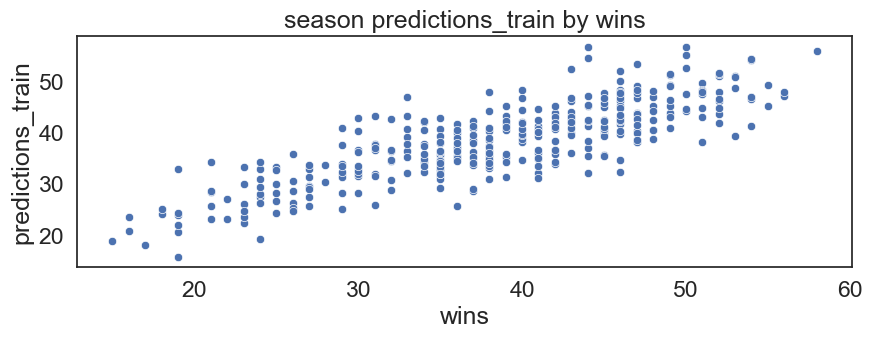

In [105]:
# Predicted wins results by actual wins for train data
Preprocessing.target_univariate_scatter(
    df=pred_train_df,
    x='wins',
    y='predictions_train',
    length=3, 
    width=10, 
    font=1.5
)

### The Interpretation of Season Predictions vs. Wins: Train

The scatter plot compares the **model predictions** (`predictions_train`) with the actual **target variable** (`wins`) for the training dataset. Here are the key observations:

#### Observations
1. **Fairly Tight Alignment**:
   - The points closely follow a diagonal trend, indicating a strong correlation between the predicted and actual values.
   - This alignment suggests that the model captures the relationship between the input features and the target variable well on the training data.

2. **Low Prediction Error**:
   - The fairly tight clustering around the diagonal line reflects relatively low prediction errors. This demonstrates that the model performs effectively in predicting the number of wins based on the given features.

3. **Model Behavior Across the Range of Wins**:
   - As the number of actual **wins** increases, the predictions consistently rise, showing that the model accurately captures the trends in the data.
   - However, there is some slight dispersion in lower and higher ranges of wins, which may suggest minor deviations or room for improvement.

---

### Combined Insights
- The model shows strong predictive accuracy on the training dataset, as evidenced by the tight clustering around the diagonal trend line.
- The relatively low error demonstrates that the model effectively fits the training data.
- While the performance is strong, further validation on test data or cross-validation would ensure the model generalizes well and avoids overfitting.

In summary, the plot highlights the model’s ability to predict regular season wins effectively within the training dataset, with minimal deviation between actual and predicted values.


## Model Testing, Evaluation, and Interpretation  

---

In [106]:
# Predict with X_test
y_pred_test = regressor.predict(X_test)
# Create data frame of predicted results
y_pred_test_df = pd.DataFrame(y_pred_test, columns=["predictions_test"]).reset_index()

# Create a single data frame with all prediction and actual y data for test data
y_test_df = pd.DataFrame(y_test, columns=["wins"]).reset_index()
pred_test_df = pd.merge(y_pred_test_df, y_test_df, on="index")
y_pred_test_df = y_pred_test_df.drop(["index"], axis=1, errors="ignore")
y_test_df = y_test_df.drop(["index"], axis=1, errors="ignore")
pred_test_df["residuals_test"] = pred_test_df["predictions_test"] - pred_test_df["wins"]

print("\n")
pred_test_df.info()
pred_test_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             156 non-null    int64  
 1   predictions_test  156 non-null    float64
 2   wins              156 non-null    int64  
 3   residuals_test    156 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 5.0 KB


,index,predictions_test,wins,residuals_test
0,0,34.404893,25,9.404893
1,1,32.445543,38,-5.554457
2,2,39.385926,39,0.385926
3,3,36.378351,37,-0.621649
4,4,45.847323,42,3.847323


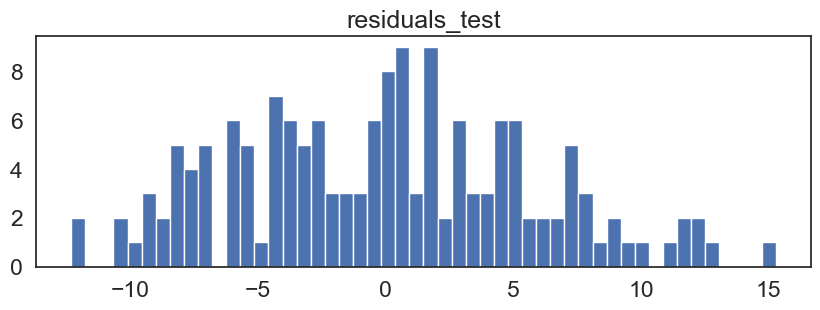


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
residuals_test,156.0,-0.138882,5.787194,-12.304221,-4.356846,0.005028,3.986439,15.282709



normality test:

statistic: 0.18
pvalue: 3.39



In [107]:
# residuals_test distribution
wins = pred_test_df[["residuals_test"]]

Preprocessing.num_univariate_histogram(
    df=wins, 
    length=3, 
    width=10, 
    rows=1, 
    col=1, 
    font=1.5
)

print(
    "\n"
    + "normality test:"
    + "\n"
    + "\n"
    + "statistic: "
    + str(round(normaltest(wins.residuals_test.values)[1], 2))
    + "\n"
    + "pvalue: "
    + str(round(normaltest(wins.residuals_test.values)[0], 2))
    + "\n"
)


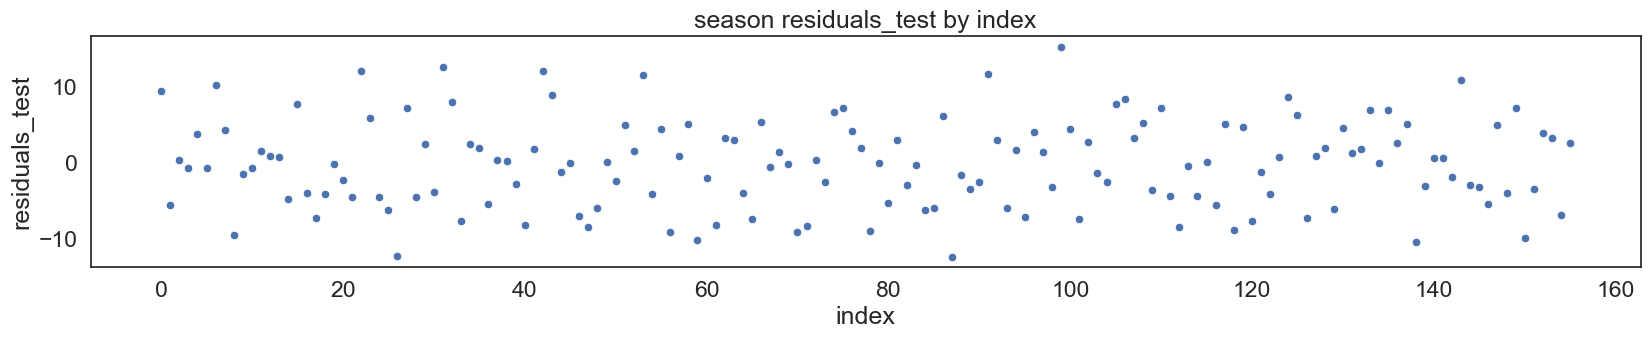

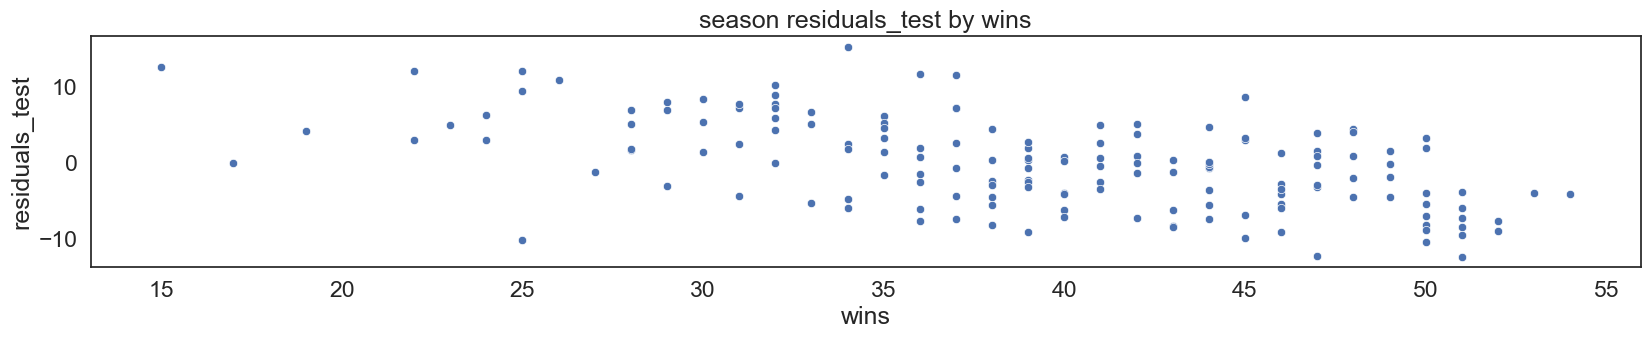

In [108]:
# residuals test by index scatter plot
Preprocessing.target_univariate_scatter(
    df=pred_test_df,
    x='index',
    y='residuals_test', 
    length=3, 
    width=20,
    font=1.5
)

# residuals test by wins scatter plot
Preprocessing.target_univariate_scatter(
    df=pred_test_df,
    x ='wins', 
    y='residuals_test', 
    length=3, 
    width=20, 
    font=1.5
)

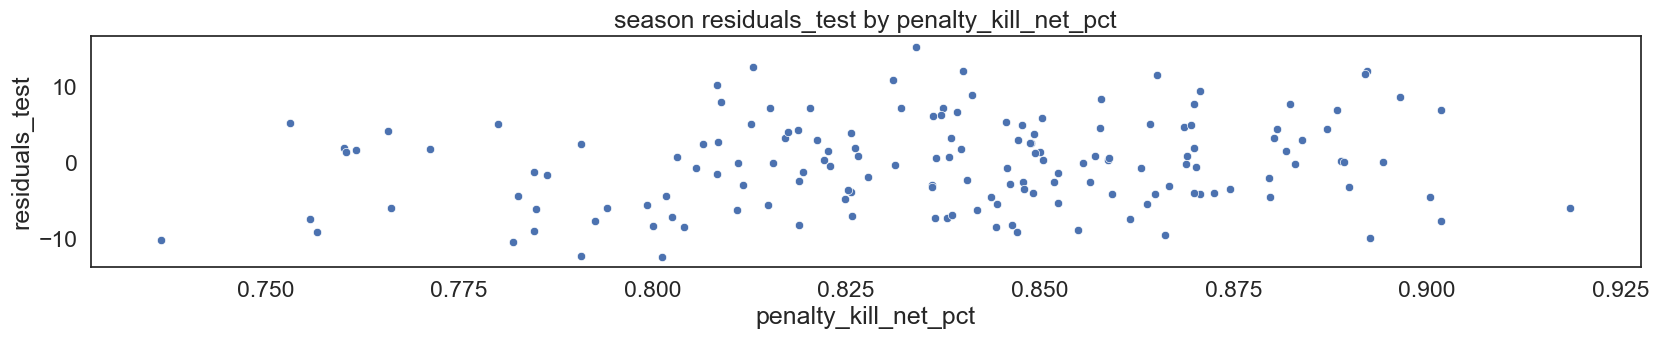

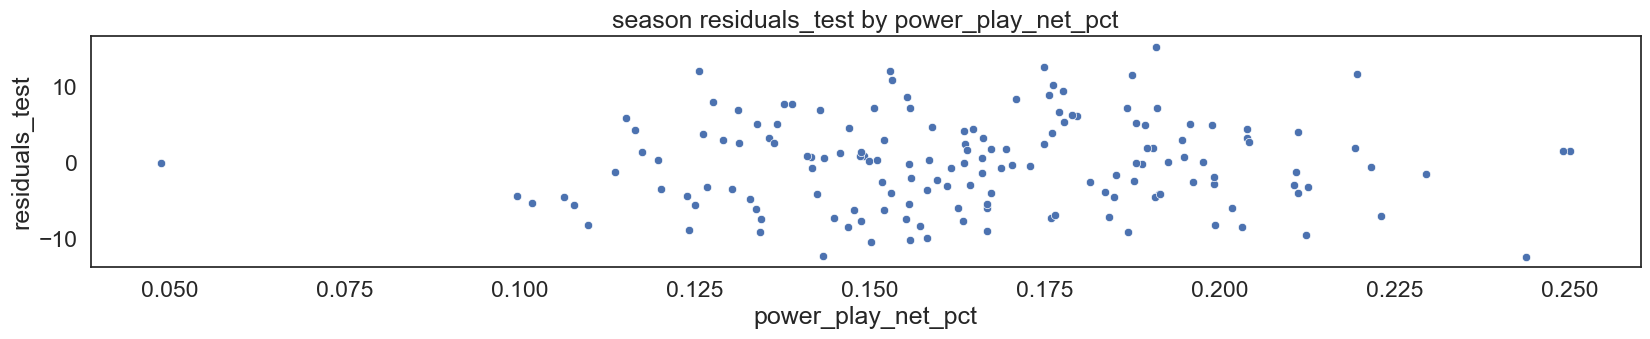

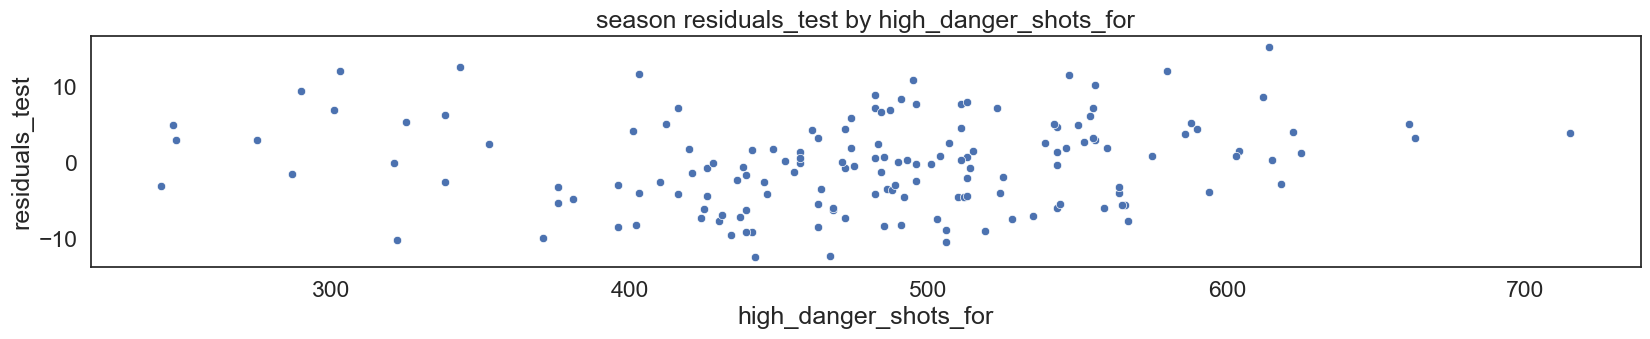

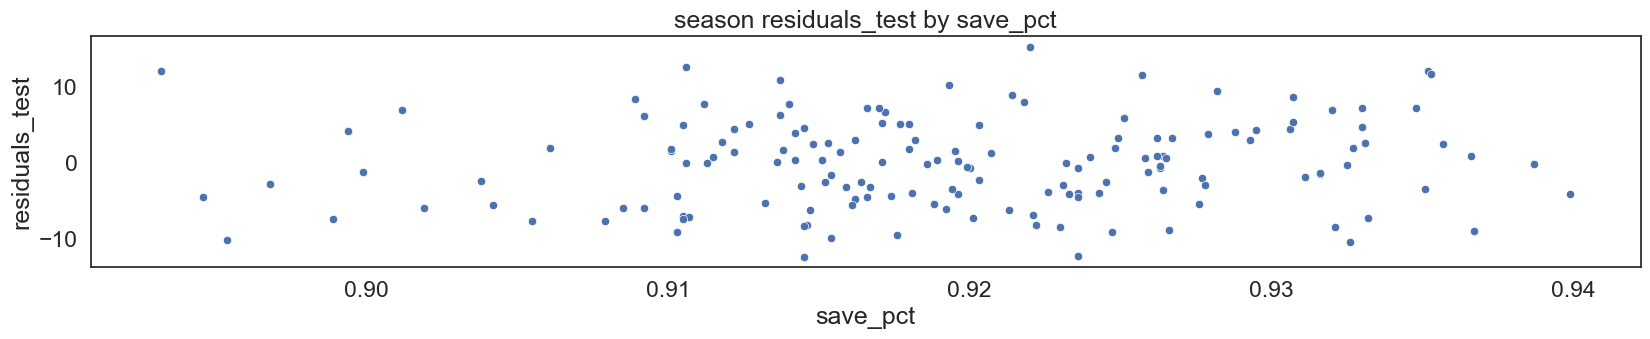

In [109]:
# residuals_test by all predictor variables plots
res_test_df = pd.concat([X_test_df, pred_test_df], axis = 1)
X_test_col = X_test_df.columns

for X in X_test_col:
    Preprocessing.target_univariate_scatter(
        df=res_test_df,
        x=X,
        y='residuals_test',
        length=3, 
        width=20, 
        font=1.5
    )

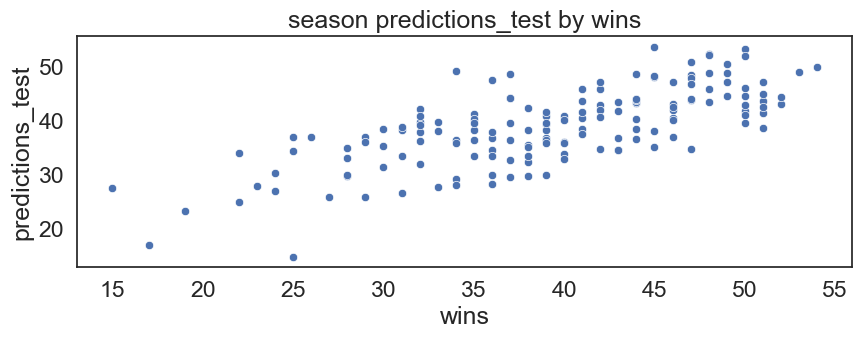

In [110]:
# Regression result metrics and summary for train data
Preprocessing.target_univariate_scatter(
    df=pred_test_df,
    x='wins', 
    y='predictions_test', 
    length=3,
    width=10, 
    font=1.5
)

### Comparison of Training and Test Results

#### Observations
1. **Similar Residual Patterns**:
   - The residuals from the test run closely resemble those from the training data, with a random distribution around zero and no noticeable patterns across the predictor variables.
   - This similarity indicates that the model generalizes well and avoids overfitting, as the errors remain consistent across both the training and test datasets.

2. **Low Prediction Errors**:
   - Both training and test residuals are primarily within the range of **-13 to 14**, further validating the model’s robustness.
   - The test residuals also show no systematic bias, reinforcing that the model’s predictions are stable across unseen data.

3. **Random Distribution Across All DVs**:
   - Just like in the training set, the test residuals are randomly distributed for all dependent variables (DVs). This confirms that the model is not disproportionately influenced by any specific predictors, maintaining a balanced fit.

4. **Outliers in Similar Ranges**:
   - The test data residuals show similar outliers to the training set, such as slightly higher dispersion at extreme values of certain predictors. This consistency suggests that these data points might inherently represent harder-to-predict cases, rather than being an issue of model bias.

---

### Key Takeaway
The test run’s results being highly similar to the training run indicates that the model is well-validated, demonstrating consistent performance across datasets. This similarity reinforces confidence in the model’s ability to generalize and accurately predict outcomes on new, unseen data.


In [111]:
# Regression evaluation metrics and summary for test data
Metrics.regression_test_metrics(
    y=y_test_df, 
    y_pred=y_pred_test_df
)


model metrics:

r-squared:                          .................0.5
mean absolute error:                ................4.71
mean squared error:                 ................33.3
root Mean squared error:            ................5.77


### Model Test Metrics Interpretation

The reported metrics provide an overview of the model's performance:

#### R-Squared (0.61)
- An **R² value of 0.50** indicates that the model explains approximately 50% of the variance in the target variable with 50% unexplained. This is lower than the **0.68** observed in the previous regression output, it suggests a weaker relationship between the predictors and the target variable.
- The drop in R² may indicate that the model has less explanatory power in this specific evaluation compared to the regression results, possibly due to different subsets of the data or cross-validation results.

#### Mean Absolute Error (4.07)
- The **MAE of 4.71** reflects the average absolute difference between the predicted and actual values. This value provides a clear and interpretable measure of the model's typical prediction error in the target variable.

#### Mean Squared Error (26.05)
- The **MSE of 33.30** indicates the average squared difference between predicted and actual values. The relatively high value suggests that large prediction errors are common, although it is more sensitive to outliers compared to MAE.

#### Root Mean Squared Error (5.1)
- The **RMSE of 5.77** provides a more interpretable version of MSE, as it is in the same units as the target variable. It reflects the typical magnitude of prediction errors, which is slightly larger than the MAE, as expected.

---

### Combined Insights
- The metrics collectively show that the model performs well but may not fully capture all the variability in the target variable (R² = 0.50).
- The differences between MAE and RMSE suggest that the model's errors are distributed relatively evenly, with no extreme outliers significantly impacting predictions.
- While these results are strong, further feature refinement or alternative modeling approaches might slightly improve performance, especially in increasing R² closer to 0.68 or beyond.
- Hockey is inherently noisy: Unlike sports like baseball (which are more statistically predictable due to isolated player actions), hockey involves continuous, fluid play with many interdependent variables (e.g., goaltending, puck luck, team chemistry). This makes modeling wins inherently challenging. As such, with an R² = 0.50, 50% of the variance is left unexplained, which could be attributed to factors like randomness, luck, injuries, officiating, or unknown variables not included in the model.

## Model Finalization

---

### Model Finalizing, Evaluation, and Interpretation  


In [112]:
# Finalize model with full rescaled data set
# Get X values
X = df[X_train_df.columns]

# Get y values
y = df[y_train_df.columns]

# Print data results
print(X.info())
display(X.head())
print(y.info())
display(y.head())

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 0 to 519
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   penalty_kill_net_pct   518 non-null    float64
 1   power_play_net_pct     518 non-null    float64
 2   high_danger_shots_for  518 non-null    int64  
 3   save_pct               518 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 20.2 KB
None


,penalty_kill_net_pct,power_play_net_pct,high_danger_shots_for,save_pct
0,0.847133,0.134375,439,0.9247
1,0.845333,0.100000,513,0.9240
2,0.857142,0.148648,504,0.9262
3,0.865979,0.202597,410,0.9262
4,0.826330,0.177248,486,0.9327


<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 0 to 519
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   wins    518 non-null    int64
dtypes: int64(1)
memory usage: 8.1 KB
None


,wins
0,46
1,35
2,42
3,42
4,47


In [113]:
# Fit and train the logistic regression model
regressor = LinearRegression()

# Scale X values (converts X values to numpy 2D array)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Convert y values to numpy 1D array
y = y.iloc[:,:].values
y = y.reshape((-1,))

# Fit regressor
regressor.fit(X, y)

LinearRegression()

In [114]:
# Predict
y_pred = regressor.predict(X)
# Create data frame of predicted results
y_pred_df = pd.DataFrame(y_pred, columns=["predictions"]).reset_index()
y_df = pd.DataFrame(y, columns=['wins']).reset_index()

pred_df = pd.merge(y_pred_df, y_df, on="index")
y_pred_df = y_pred_df.drop(["index"], axis=1, errors="ignore")
y_df = y_df.drop(["index"], axis=1, errors="ignore")
pred_df["residuals"] = pred_df["predictions"] - pred_df["wins"]

print("\n")
pred_df.info()
pred_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        518 non-null    int64  
 1   predictions  518 non-null    float64
 2   wins         518 non-null    int64  
 3   residuals    518 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 16.3 KB


,index,predictions,wins,residuals
0,0,36.866481,46,-9.133519
1,1,38.098695,35,3.098695
2,2,42.581702,42,0.581702
3,3,41.927636,42,-0.072364
4,4,43.647247,47,-3.352753


In [115]:
# Regression evaluation metrics and summary
Metrics.regression_test_metrics(
    y=y_df, 
    y_pred=y_pred_df
)


model metrics:

r-squared:                          ................0.64
mean absolute error:                .................4.3
mean squared error:                 ...............28.73
root Mean squared error:            ................5.36


The above block of code finalizes that model by training on all data available (scaled train and test data).

The final model results are shown above.

In [116]:
# Save the model
path = os.path.abspath(
    os.path.join(
        current_dir,
        "..",
        "..",
        r"Regression_Analysis/Regression_Models/NHL_Regular_Season_Wins_Linear_Regression_Model.pkl",
    )
)
dump(regressor, open(path, 'wb'))

Save the regression model.

In [117]:
# load the model
path = os.path.abspath(
    os.path.join(
        current_dir, 
        '..', 
        '..', 
        r'Regression_Analysis/Regression_Models/NHL_Regular_Season_Wins_Linear_Regression_Model.pkl'
    )
)
regressor = load(open(path, 'rb'))

Load the regression model.

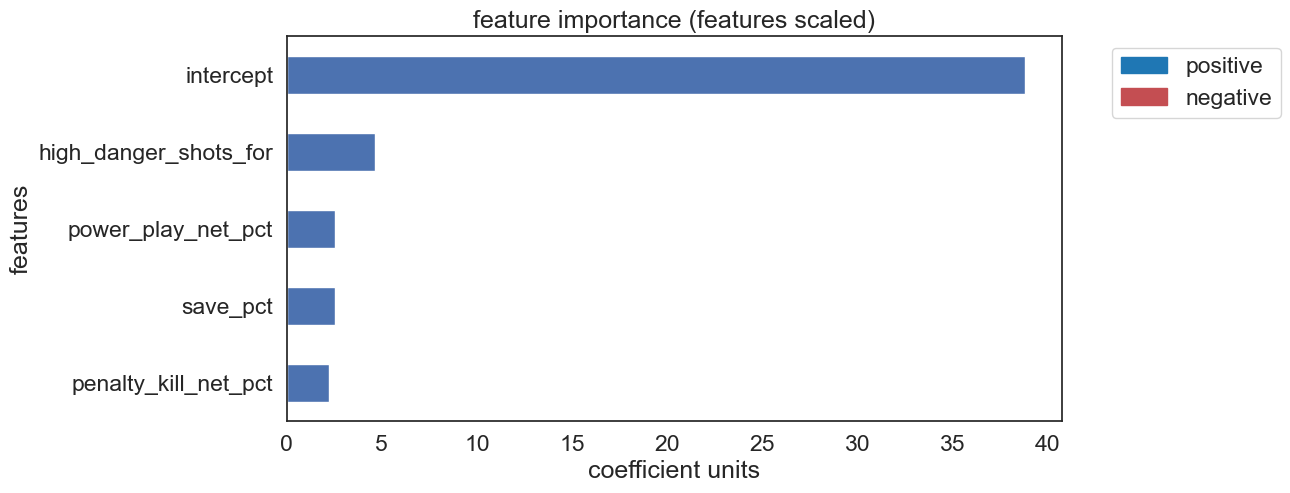

,features,coef,positive
4,intercept,38.785714,True
3,high_danger_shots_for,4.653595,True
2,power_play_net_pct,2.574472,True
1,save_pct,2.557465,True
0,penalty_kill_net_pct,2.237169,True


In [118]:
# Regressor Summary
Xlabels = X_train_df.columns

# Convert X to data frame
X = pd.DataFrame(X, columns = Xlabels)

# Feature improtance bar chart
Metrics.regression_feature_importance(
    model=regressor,
    X_cols=X,
    font=1.5,
    length=5,
    width=10,
    pos='b',
    neg='r'
)

## Feature Importance and Coefficients Analysis

The visual and tabular representation of feature importance highlights the scaled coefficients from the regression model. Below is a breakdown of each feature’s impact on the target variable, based on the chart and table provided.

---

### Key Positive Predictors

#### 1. High Danger Shots For (4.65)
- This is the largest *positive* coefficient (excluding the intercept).  
- Suggests that **generating a higher volume of high danger scoring opportunities** still correlates with improved performance or outcomes.  
- Implies that sustained offensive pressure in prime scoring areas can have a beneficial cumulative effect.

#### 2. Power Play Net Percentage (2.57)
- Suggests that **efficient power-play execution** has a clear positive impact.  
- Converting on power-play opportunities shifts momentum and contributes significantly to overall performance.

#### 3. Save Percentage (2.55)
- Emphasizes that successfully **stopping scoring chances of any kind** is crucial.  
- Reinforces the idea that high-quality goaltending or defense drives positive results.

#### 4. Penalty Kill Net Percentage (2.34)
- Strong penalty-killing performance **reduces opponents’ scoring and boosts overall team success**.  
- Indicates the critical role of defensive special teams in achieving favorable outcomes.

---

### Intercept (38.79)
- Represents the baseline outcome when all other predictors are set to zero.  
- While large in magnitude, it primarily **anchors the regression model** rather than providing direct tactical insight.

---

### Combined Insights
- **Offense Matters:** A Large positive coefficient for **high danger shots for** underscore the value of shot volume in high quality scoring areas. This means teams should set their strategy to look to find a way into these areas.
- **Special Teams Are Key:** The positive impacts of **penalty kill and power play net percentages** show how pivotal special teams execution can be.
- **Defense/Goaltending Impact:** A positive coefficient for **save percentage** reminds us that stopping quality chances against is just as important as generating them.  
- **Intercept as a Baseline:** The high intercept suggests a strong baseline level in the model, with the other features serving as refinements or adjustments around that baseline.

---

### Next Steps
- **Contextual Analysis:** Explore situational contexts (home vs. away, playoff vs. regular season) to see if these coefficients hold or vary.
- **Player-Level Contributions:** Break down which players or line combinations most influence each metric.
- **Predictive Validation:** Assess model performance over time or across new seasons to confirm the stability of these feature effects.

---

In conclusion, the model points to **sustained offensive generation in prime areas on the ice and strong special teams play** as leading indicators of success. Meanwhile, **stopping high-danger goals against** remains paramount to maintaining positive outcomes.

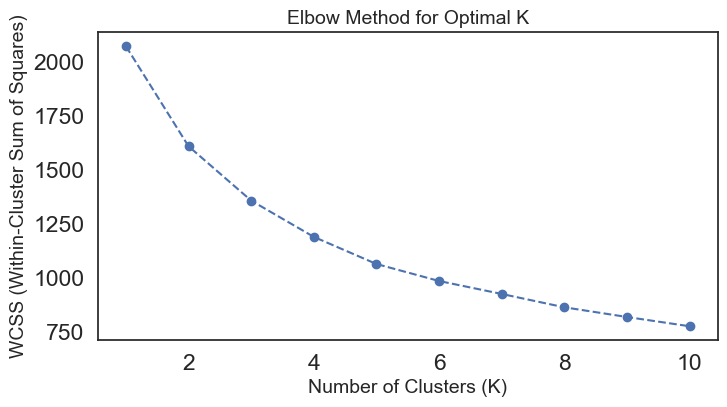

In [121]:
# Choose the number of clusters (Elbow Method)
wcss = []
K_range = range(1, 11)  # Testing 1 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve to determine the best K
plt.figure(figsize=(8, 4))
plt.plot(K_range, wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)", fontsize=14)
plt.ylabel("WCSS (Within-Cluster Sum of Squares)", fontsize=14)
plt.title("Elbow Method for Optimal K", fontsize=14)
plt.show()

In [122]:
cluster_df = X.copy()
y_df = pd.DataFrame(y, columns=['wins'])
cluster_df = pd.concat([y_df, X], axis = 1)
cluster_df.head(3)

,wins,penalty_kill_net_pct,power_play_net_pct,high_danger_shots_for,save_pct
0,46,0.389037,-0.886556,-0.413304,0.553746
1,35,0.337761,-1.868425,0.463731,0.472947
2,42,0.674162,-0.478870,0.357065,0.726883


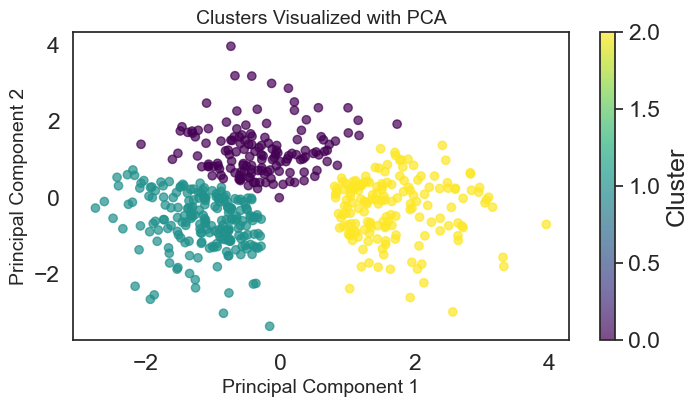

In [129]:
# Apply K-Means Clustering (Using Optimal K)
optimal_k = 3  # Change based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add Cluster Labels to DataFrame
cluster_df["Clusters"] = clusters

# Reduce dimensions to visualize clusters
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 4))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.title("Clusters Visualized with PCA", fontsize=14)
plt.colorbar(label="Cluster")
plt.show()

# Clustering Analysis and Visual Interpretations

Below are two common plots used to analyze and validate clustering results: a **PCA-based cluster visualization** and an **Elbow plot** for determining the optimal number of clusters.

---

## 1. PCA-Based Cluster Visualization

- **Purpose**: This plot shows the data points projected onto the first two Principal Components (PC1 and PC2). The colors represent the different clusters identified by the clustering algorithm.
- **Observations**:
  - The data naturally separates into three distinct groups (purple, teal, and yellow).
  - The separation along PC1 and PC2 suggests that these components capture the majority of the variance that distinguishes the clusters.
  - Each cluster is relatively tight and distinct from the others, indicating a clear grouping structure.
- **Insights**:
  - Visual confirmation that the **chosen number of clusters** (in this case, three) does a good job separating the data.
  - Observing how these clusters map onto principal components can give hints about the underlying features driving separation.

---

## 2. Elbow Plot for Optimal K

- **Purpose**: The Elbow Method helps decide the optimal number of clusters (K) by plotting the Within-Cluster Sum of Squares (WCSS) for different K values.
- **Observations**:
  - The WCSS decreases sharply from **K=1** to **K=3**, indicating that adding more clusters significantly improves the fit up to that point.
  - After **K=3**, the rate of decrease in WCSS tapers off, forming an “elbow.”
  - Beyond **K=4**, the marginal gain from adding additional clusters diminishes.
- **Insights**:
  - The “elbow” typically represents a balance between **overfitting** (too many clusters) and **underfitting** (too few clusters).
  - Here, **K=3** emerges as the most likely optimal choice, aligning with the visual separation seen in the PCA plot.

---

## Combined Interpretation

1. **Optimal Number of Clusters**  
   - Both the PCA visualization and the Elbow plot suggest **three** well-separated clusters are present in the data.

2. **Cluster Separation**  
   - The distinct grouping in the PCA plot indicates that the clustering algorithm is capturing meaningful patterns, with minimal overlap among clusters.

3. **Actionable Insights**  
   - If these clusters represent customer segments, product categories, or any other entity types, stakeholders can tailor strategies or analyses specifically to each group.  
   - Future steps might include **examining cluster centroids** or **performing additional feature-level analysis** to understand what drives each cluster’s separation.

By combining the **visual representation in PCA** with the **quantitative Elbow method**, we gain confidence that the clustering solution (K=3) both **minimizes within-cluster variance** and **maximizes inter-cluster separation**.


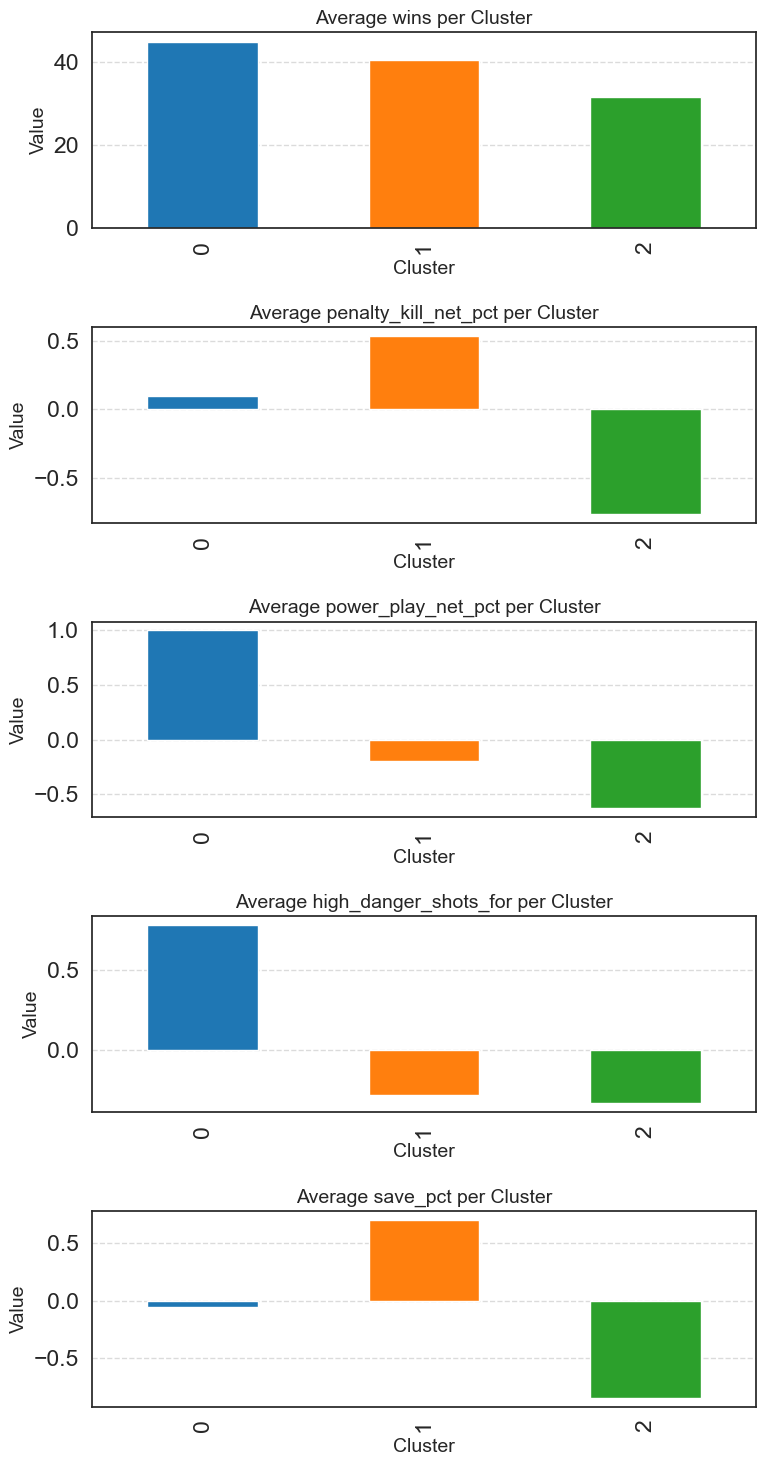

In [130]:
# Assuming your clustered DataFrame has a "Cluster" column
cluster_averages = cluster_df.groupby("Clusters").mean()

# Plot bar charts for each feature
num_features = cluster_averages.shape[1]
fig, axes = plt.subplots(nrows=num_features, figsize=(8, num_features * 3))

if num_features == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one feature

for ax, column in zip(axes, cluster_averages.columns):
    cluster_averages[column].plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
    ax.set_title(f"Average {column} per Cluster", fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.set_xlabel("Cluster", fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Analysis of Cluster Performance and Feature Importance

### Overall Cluster Observations

#### 1. Cluster 0 (Blue  
- **Highest average wins**, suggesting teams in this cluster are the most successful.  
- **Strong offensive production**, especially in high-danger shot generation.  
- **Positive power play impact**, indicating efficiency in capitalizing on man advantages.  
- **Moderate save percentage**, meaning goaltending is stable but not necessarily a primary strength.  

#### 2. Cluster 1 (Orange  
- **Moderate wins**, placing this group between the highest and lowest performers.  
- **Strong penalty kill efficiency**, a defining characteristic of this cluster.  
- **Slightly negative power play impact**, meaning these teams may struggle to convert on special teams.  
- **Best save percentage**, indicating goaltending plays a key role in their performance.  

#### 3. Cluster 2 (Green  
- **Lowest average wins**, making this the weakest-performing group overall.  
- **Struggles on both the power play and penalty kill**, leading to net-negative special teams performance.  
- **Lower high-danger shot generation**, indicating offensive struggles.  
- **Weak save percentage**, possibly contributing to defensive inefficiencies.  

---

### Linking Regression Coefficients to Cluster Insights 

The regression analysis highlighted **positive coefficients** for save percentage, high-danger shots for, and power play net percentage, while penalty kill net percentage and high-danger shots against had mixed or negative impacts. This suggests that strong goaltending, efficient offensive play, and special teams success are key drivers of overall performance.  

Overall, these clusters reinforce the regression coefficients’ story: **teams perform best when they generate quality scoring chances, maintain strong goaltending, and capitalize on special teams, while limiting high-danger opportunities against.**  